In [1]:
#importing the libraries we need
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
import cv2
from torch.utils.data import Dataset, DataLoader
from torch import nn
import re
from torch.autograd import Variable

from utils import *
from  models.C3DModel import C3DModel
from models.trainC3D import trainC3D

torch.cuda.empty_cache()

In [2]:
#assigning the type of device that we will work on
device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
#device =  torch.device('cpu')

In [3]:
train_frames = pd.read_csv('frames_train_1.csv')
test_frames = pd.read_csv('frames_test_1.csv')

train_videos = pd.read_csv('video_train_1.csv')
test_videos = pd.read_csv('video_test_1_classes.csv')

In [4]:
train_videos.head()

,name,class,num_frames
0,v_ApplyEyeMakeup_g08_c01.avi,1,24
1,v_ApplyEyeMakeup_g08_c02.avi,1,23
2,v_ApplyEyeMakeup_g08_c03.avi,1,29
3,v_ApplyEyeMakeup_g08_c04.avi,1,44
4,v_ApplyEyeMakeup_g08_c05.avi,1,55


In [5]:
test_videos.head()

,name,num_frames,class
0,v_ApplyEyeMakeup_g01_c01.avi,32,1
1,v_ApplyEyeMakeup_g01_c02.avi,24,1
2,v_ApplyEyeMakeup_g01_c03.avi,51,1
3,v_ApplyEyeMakeup_g01_c04.avi,47,1
4,v_ApplyEyeMakeup_g01_c05.avi,59,1


# Let's train our C3D model :D

In [6]:
class Resize(object):
    """Rescale the image to a given size.

    Args:
        output_size (tuple): Desired output size of the image. should be like (new_h , new_w)
    """

    def __init__(self, output_size):
        
        assert len(output_size) == 2 , "the output size must be of lenght 2 >>> (new_h , new_w)"
        self.output_size = output_size

    def __call__(self, images):
        
        new_h , new_w = self.output_size
        
        resized_images = np.zeros( (len(images) , new_h , new_w , 3) )
        
        for i , image in enumerate(images) :

            resized_images[i] = cv2.resize(src = image, dsize = (new_w,new_h))


        return resized_images


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, images):

        # swap color axis because
        # numpy images: T x H x W x C
        # torch image: C x T X H X W
        
        images = images.transpose((3, 0, 1, 2))
        
        return torch.from_numpy(images).float() / 255

In [7]:
seq_len = 16 #the length of the sequence
overlap = 8 #overlap between every two consecutive sequences

#validation/train ratio
validation_ratio = 0.1

tr_Vids , val_Vids = vali_train_splite(validation_ratio , train_videos)

tr_seqs = []
for i in range(len(tr_Vids)):
    
    name = tr_Vids['name'][i]
    label = tr_Vids['class'][i]
    numOfFrames = tr_Vids['num_frames'][i]
    seqs = getSequences (numOfFrames , seq_len , overlap = overlap)
    
    tr_seqs += [(name , label , sequence) for sequence in seqs]
    
tr_seqs = pd.DataFrame(tr_seqs , columns = ['name', 'class' ,'seq'])


val_seqs = []
for i in range(len(val_Vids)):
    
    name = val_Vids['name'][i]
    label = val_Vids['class'][i]
    numOfFrames = val_Vids['num_frames'][i]
    seqs = getSequences (numOfFrames , seq_len , overlap = overlap)
    
    val_seqs += [(name , label , sequence) for sequence in seqs]
    
val_seqs = pd.DataFrame(val_seqs , columns = ['name', 'class' ,'seq'])

In [8]:
Image_output_size = (128,128) #output size of the images

train_batch_size = 8
val_batch_size = 8


#the transform steps that we will execute on the images
transform  =torchvision.transforms.Compose([
    Resize(Image_output_size), #resizing the images
    ToTensor() # reshaping and transforming the images to Tensors
])

#.sample(n=train_batch_size).reset_index()

#intializing the image generator
train_gen = UCF101DatasetSeqs(frame_seq_names =tr_seqs , img_dir ='Train_Frames_1/', shuffle = True , transform = transform)

#intializing the validation image generator
val_gen = UCF101DatasetSeqs(frame_seq_names =val_seqs, img_dir ='Train_Frames_1/', shuffle = True , transform = transform)

#intializing the train batches loader !!!
train_loader = DataLoader(train_gen , batch_size= train_batch_size , shuffle = True)

#intializing the val batches loader !!!
val_loader = DataLoader(val_gen , batch_size= val_batch_size , shuffle = True)

In [9]:
output_features = 101 #the number of labels
lr = 0.0001

model = C3DModel(output_features).to(device)   #intializing the model
lossFunc = nn.NLLLoss() #the loss funstion to train on (crossEntropy since it's a classification task)
optimizer = torch.optim.Adam(model.parameters(), lr = lr) #the optimization algorithm we use during training

epochs = 2 #num of epoches

In [10]:
tr_loss_lis, tr_acc_lis, val_loss_lis, val_acc_lis= trainC3D(model , lossFunc, optimizer , epochs , train_loader ,val_loader , device)

[1, 1] train_loss: 4.59645 train_acc: 0.00000 val_loss: 4.62450 val_acc: 0.00000
[1, 10] train_loss: 4.59738 train_acc: 0.00000 val_loss: 4.59733 val_acc: 1.25000
[1, 20] train_loss: 4.45587 train_acc: 6.25000 val_loss: 4.62324 val_acc: 5.00000
[1, 30] train_loss: 4.53513 train_acc: 6.25000 val_loss: 4.70944 val_acc: 5.00000
[1, 40] train_loss: 4.63648 train_acc: 1.25000 val_loss: 4.72111 val_acc: 1.25000
[1, 50] train_loss: 4.47464 train_acc: 3.75000 val_loss: 4.57863 val_acc: 2.50000
[1, 60] train_loss: 4.53913 train_acc: 6.25000 val_loss: 4.14876 val_acc: 11.25000
[1, 70] train_loss: 4.44738 train_acc: 2.50000 val_loss: 4.35111 val_acc: 6.25000
[1, 80] train_loss: 4.54168 train_acc: 3.75000 val_loss: 4.52511 val_acc: 2.50000
[1, 90] train_loss: 4.59659 train_acc: 6.25000 val_loss: 4.43040 val_acc: 8.75000
[1, 100] train_loss: 4.46812 train_acc: 3.75000 val_loss: 4.37925 val_acc: 8.75000
[1, 110] train_loss: 4.41005 train_acc: 8.75000 val_loss: 4.37725 val_acc: 8.75000
[1, 120] train

[1, 970] train_loss: 3.18981 train_acc: 25.00000 val_loss: 3.36412 val_acc: 17.50000
[1, 980] train_loss: 3.12932 train_acc: 26.25000 val_loss: 3.43093 val_acc: 22.50000
[1, 990] train_loss: 3.15242 train_acc: 25.00000 val_loss: 3.07485 val_acc: 31.25000
[1, 1000] train_loss: 3.28786 train_acc: 22.50000 val_loss: 3.59681 val_acc: 20.00000
[1, 1010] train_loss: 3.21279 train_acc: 21.25000 val_loss: 3.54533 val_acc: 22.50000
[1, 1020] train_loss: 3.09945 train_acc: 26.25000 val_loss: 2.97165 val_acc: 28.75000
[1, 1030] train_loss: 3.37111 train_acc: 21.25000 val_loss: 2.59611 val_acc: 37.50000
[1, 1040] train_loss: 3.04386 train_acc: 25.00000 val_loss: 2.90807 val_acc: 32.50000
[1, 1050] train_loss: 2.97633 train_acc: 22.50000 val_loss: 3.35851 val_acc: 21.25000
[1, 1060] train_loss: 3.36070 train_acc: 21.25000 val_loss: 3.22427 val_acc: 27.50000
[1, 1070] train_loss: 3.20840 train_acc: 22.50000 val_loss: 3.21710 val_acc: 33.75000
[1, 1080] train_loss: 2.93712 train_acc: 27.50000 val_los

[1, 1920] train_loss: 2.51761 train_acc: 40.00000 val_loss: 2.48836 val_acc: 42.50000
[1, 1930] train_loss: 2.35613 train_acc: 40.00000 val_loss: 2.55370 val_acc: 35.00000
[1, 1940] train_loss: 2.21124 train_acc: 52.50000 val_loss: 2.60122 val_acc: 40.00000
[1, 1950] train_loss: 2.72515 train_acc: 31.25000 val_loss: 2.57612 val_acc: 43.75000
[1, 1960] train_loss: 2.42190 train_acc: 40.00000 val_loss: 2.00535 val_acc: 51.25000
[1, 1970] train_loss: 2.20547 train_acc: 53.75000 val_loss: 2.63280 val_acc: 40.00000
[1, 1980] train_loss: 2.43014 train_acc: 42.50000 val_loss: 2.30715 val_acc: 46.25000
[1, 1990] train_loss: 2.45680 train_acc: 48.75000 val_loss: 2.26047 val_acc: 48.75000
[1, 2000] train_loss: 2.27037 train_acc: 42.50000 val_loss: 1.99691 val_acc: 51.25000
[1, 2010] train_loss: 2.37170 train_acc: 45.00000 val_loss: 2.18747 val_acc: 46.25000
[1, 2020] train_loss: 1.96157 train_acc: 52.50000 val_loss: 2.10783 val_acc: 47.50000
[1, 2030] train_loss: 2.22294 train_acc: 42.50000 val_

[1, 2870] train_loss: 1.61531 train_acc: 60.00000 val_loss: 1.78236 val_acc: 58.75000
[1, 2880] train_loss: 1.65395 train_acc: 58.75000 val_loss: 1.25310 val_acc: 67.50000
[1, 2890] train_loss: 1.57214 train_acc: 62.50000 val_loss: 1.67620 val_acc: 53.75000
[1, 2900] train_loss: 1.33327 train_acc: 63.75000 val_loss: 1.94301 val_acc: 56.25000
[1, 2910] train_loss: 1.74236 train_acc: 55.00000 val_loss: 1.77166 val_acc: 55.00000
[1, 2920] train_loss: 1.53086 train_acc: 52.50000 val_loss: 2.48249 val_acc: 42.50000
[1, 2930] train_loss: 1.79832 train_acc: 62.50000 val_loss: 1.73307 val_acc: 57.50000
[1, 2940] train_loss: 1.97795 train_acc: 55.00000 val_loss: 1.77722 val_acc: 53.75000
[1, 2950] train_loss: 1.65100 train_acc: 60.00000 val_loss: 1.87178 val_acc: 55.00000
[1, 2960] train_loss: 1.51940 train_acc: 70.00000 val_loss: 1.90614 val_acc: 56.25000
[1, 2970] train_loss: 1.92299 train_acc: 46.25000 val_loss: 2.21678 val_acc: 47.50000
[1, 2980] train_loss: 1.52606 train_acc: 58.75000 val_

[1, 3820] train_loss: 1.44654 train_acc: 58.75000 val_loss: 1.50753 val_acc: 67.50000
[1, 3830] train_loss: 1.45658 train_acc: 63.75000 val_loss: 1.60905 val_acc: 60.00000
[1, 3840] train_loss: 1.62726 train_acc: 62.50000 val_loss: 1.43715 val_acc: 63.75000
[1, 3850] train_loss: 1.55524 train_acc: 62.50000 val_loss: 1.54410 val_acc: 62.50000
[1, 3860] train_loss: 1.40408 train_acc: 66.25000 val_loss: 1.91426 val_acc: 55.00000
[1, 3870] train_loss: 1.04283 train_acc: 73.75000 val_loss: 1.71556 val_acc: 53.75000
[1, 3880] train_loss: 1.03811 train_acc: 72.50000 val_loss: 1.67722 val_acc: 55.00000
[1, 3890] train_loss: 1.47128 train_acc: 65.00000 val_loss: 1.71602 val_acc: 57.50000
[1, 3900] train_loss: 1.17025 train_acc: 76.25000 val_loss: 1.02708 val_acc: 73.75000
[1, 3910] train_loss: 1.14344 train_acc: 72.50000 val_loss: 1.76989 val_acc: 55.00000
[1, 3920] train_loss: 1.31583 train_acc: 63.75000 val_loss: 1.86478 val_acc: 47.50000
[1, 3930] train_loss: 1.50661 train_acc: 56.25000 val_

[2, 350] train_loss: 0.80604 train_acc: 78.75000 val_loss: 1.30693 val_acc: 67.50000
[2, 360] train_loss: 0.84792 train_acc: 77.50000 val_loss: 1.02399 val_acc: 72.50000
[2, 370] train_loss: 1.11626 train_acc: 70.00000 val_loss: 1.12869 val_acc: 70.00000
[2, 380] train_loss: 0.74616 train_acc: 80.00000 val_loss: 1.32740 val_acc: 65.00000
[2, 390] train_loss: 1.11953 train_acc: 72.50000 val_loss: 1.20965 val_acc: 66.25000
[2, 400] train_loss: 0.97092 train_acc: 76.25000 val_loss: 1.16039 val_acc: 71.25000
[2, 410] train_loss: 0.88924 train_acc: 77.50000 val_loss: 1.29527 val_acc: 68.75000
[2, 420] train_loss: 0.79781 train_acc: 80.00000 val_loss: 1.31553 val_acc: 68.75000
[2, 430] train_loss: 0.69830 train_acc: 78.75000 val_loss: 1.53365 val_acc: 60.00000
[2, 440] train_loss: 1.03712 train_acc: 75.00000 val_loss: 0.96526 val_acc: 77.50000
[2, 450] train_loss: 0.82676 train_acc: 83.75000 val_loss: 1.54442 val_acc: 62.50000
[2, 460] train_loss: 0.96451 train_acc: 71.25000 val_loss: 1.3408

[2, 1310] train_loss: 0.91477 train_acc: 73.75000 val_loss: 1.17729 val_acc: 72.50000
[2, 1320] train_loss: 1.05657 train_acc: 75.00000 val_loss: 1.31531 val_acc: 68.75000
[2, 1330] train_loss: 1.04444 train_acc: 72.50000 val_loss: 1.33631 val_acc: 65.00000
[2, 1340] train_loss: 0.82399 train_acc: 77.50000 val_loss: 1.08847 val_acc: 71.25000
[2, 1350] train_loss: 1.08048 train_acc: 70.00000 val_loss: 1.55232 val_acc: 68.75000
[2, 1360] train_loss: 0.83498 train_acc: 78.75000 val_loss: 1.42266 val_acc: 62.50000
[2, 1370] train_loss: 1.11944 train_acc: 68.75000 val_loss: 1.25476 val_acc: 67.50000
[2, 1380] train_loss: 1.07685 train_acc: 68.75000 val_loss: 1.20324 val_acc: 67.50000
[2, 1390] train_loss: 0.67306 train_acc: 82.50000 val_loss: 1.08118 val_acc: 70.00000
[2, 1400] train_loss: 0.84631 train_acc: 77.50000 val_loss: 1.22443 val_acc: 70.00000
[2, 1410] train_loss: 1.07457 train_acc: 75.00000 val_loss: 1.26211 val_acc: 71.25000
[2, 1420] train_loss: 0.75020 train_acc: 80.00000 val_

[2, 2260] train_loss: 0.89117 train_acc: 78.75000 val_loss: 0.80260 val_acc: 75.00000
[2, 2270] train_loss: 0.62417 train_acc: 83.75000 val_loss: 1.25833 val_acc: 71.25000
[2, 2280] train_loss: 0.62453 train_acc: 85.00000 val_loss: 1.42717 val_acc: 67.50000
[2, 2290] train_loss: 0.68169 train_acc: 80.00000 val_loss: 0.87439 val_acc: 81.25000
[2, 2300] train_loss: 0.78622 train_acc: 80.00000 val_loss: 0.94395 val_acc: 71.25000
[2, 2310] train_loss: 0.80888 train_acc: 80.00000 val_loss: 1.23026 val_acc: 68.75000
[2, 2320] train_loss: 0.71323 train_acc: 81.25000 val_loss: 1.20690 val_acc: 73.75000
[2, 2330] train_loss: 0.67070 train_acc: 82.50000 val_loss: 1.19510 val_acc: 68.75000
[2, 2340] train_loss: 0.97122 train_acc: 75.00000 val_loss: 1.36701 val_acc: 70.00000
[2, 2350] train_loss: 0.64304 train_acc: 81.25000 val_loss: 0.74019 val_acc: 80.00000
[2, 2360] train_loss: 0.95494 train_acc: 76.25000 val_loss: 1.23172 val_acc: 72.50000
[2, 2370] train_loss: 0.83188 train_acc: 81.25000 val_

[2, 3210] train_loss: 0.41619 train_acc: 87.50000 val_loss: 1.08090 val_acc: 76.25000
[2, 3220] train_loss: 0.89280 train_acc: 77.50000 val_loss: 0.75210 val_acc: 78.75000
[2, 3230] train_loss: 0.49549 train_acc: 87.50000 val_loss: 1.23315 val_acc: 68.75000
[2, 3240] train_loss: 0.65848 train_acc: 81.25000 val_loss: 1.27698 val_acc: 75.00000
[2, 3250] train_loss: 0.73312 train_acc: 78.75000 val_loss: 1.28418 val_acc: 73.75000
[2, 3260] train_loss: 0.61515 train_acc: 86.25000 val_loss: 0.78635 val_acc: 78.75000
[2, 3270] train_loss: 0.77090 train_acc: 81.25000 val_loss: 0.64546 val_acc: 86.25000
[2, 3280] train_loss: 0.72193 train_acc: 82.50000 val_loss: 0.67668 val_acc: 77.50000
[2, 3290] train_loss: 0.60469 train_acc: 82.50000 val_loss: 0.77441 val_acc: 80.00000
[2, 3300] train_loss: 0.71708 train_acc: 82.50000 val_loss: 0.92276 val_acc: 73.75000
[2, 3310] train_loss: 0.55242 train_acc: 83.75000 val_loss: 1.41404 val_acc: 65.00000
[2, 3320] train_loss: 0.87739 train_acc: 72.50000 val_

[2, 4160] train_loss: 0.62023 train_acc: 81.25000 val_loss: 0.87854 val_acc: 76.25000
[2, 4170] train_loss: 0.70225 train_acc: 82.50000 val_loss: 0.75488 val_acc: 76.25000
[2, 4180] train_loss: 0.63797 train_acc: 87.50000 val_loss: 0.82717 val_acc: 82.50000
[2, 4190] train_loss: 0.67144 train_acc: 82.50000 val_loss: 1.09670 val_acc: 76.25000
[2, 4200] train_loss: 0.39524 train_acc: 87.50000 val_loss: 0.70495 val_acc: 80.00000
[2, 4210] train_loss: 0.30981 train_acc: 90.00000 val_loss: 0.98199 val_acc: 73.75000
[2, 4220] train_loss: 0.65371 train_acc: 81.25000 val_loss: 1.11497 val_acc: 73.75000
[2, 4230] train_loss: 0.82658 train_acc: 80.00000 val_loss: 0.78798 val_acc: 80.00000
[2, 4240] train_loss: 0.58909 train_acc: 86.25000 val_loss: 0.71127 val_acc: 80.00000
[2, 4250] train_loss: 0.50597 train_acc: 87.50000 val_loss: 0.96119 val_acc: 78.75000
[2, 4260] train_loss: 0.77224 train_acc: 81.25000 val_loss: 1.17588 val_acc: 77.50000
[2, 4270] train_loss: 0.54207 train_acc: 86.25000 val_

In [12]:
torch.save(model.state_dict(), 'Saved weights/C3D.pth')

In [13]:
#save the progress
with open("C3D Acc and Loss.txt", "w") as file:
    file.write(str(tr_loss_lis)+'seperator')
    file.write(str(tr_acc_lis)+'seperator')
    file.write(str(val_loss_lis)+'seperator')
    file.write(str(val_acc_lis)+'seperator')

In [15]:
new_tr_loss_lis = np.array(tr_loss_lis[:-4]).reshape(-1 , 10).mean(axis = 1) / 10
new_val_loss_lis = np.array(val_loss_lis[:-4]).reshape(-1 , 10).mean(axis = 1) / 10

new_tr_acc_lis = 100 * np.array(tr_acc_lis[:-4]).reshape(-1 , 10).mean(axis = 1) /10
new_val_acc_lis = 100 * np.array(val_acc_lis[:-4]).reshape(-1 , 10).mean(axis = 1) / 10

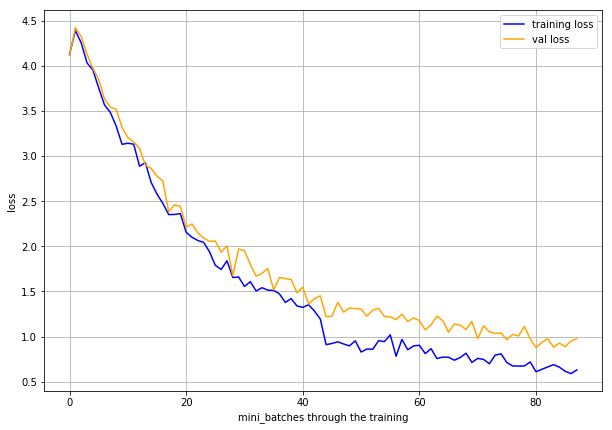

In [16]:
plt.figure(figsize= (10,7))
plt.plot(np.array(new_tr_loss_lis),'b',label='training loss')
plt.plot(np.array(new_val_loss_lis),'orange',label='val loss')
plt.xlabel('mini_batches through the training')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

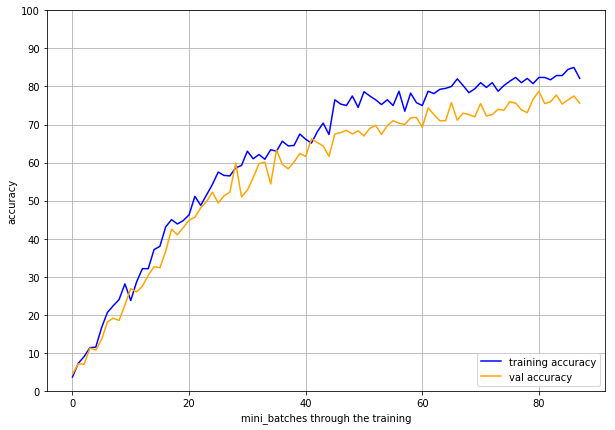

In [17]:
plt.figure(figsize= (10,7))
plt.plot(new_tr_acc_lis,'b',label='training accuracy')
plt.plot(new_val_acc_lis,'orange',label='val accuracy')
plt.xlabel('mini_batches through the training')
plt.ylabel('accuracy')
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.ylim(0,100)
plt.grid(True)
plt.legend(loc = 4)